In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
trafic_index = dict(pd.read_csv('data/processed/Full_data_set.csv', parse_dates = [8]).Reservation_Time.dt.hour.value_counts())

## Simple network

In [4]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

# No more than 3 days
df = df[df.time_to_reservation < 72]

# Remove zones with too little support
df = df[~df.leave_zone.isin((df.leave_zone.value_counts() < 30).index[df.leave_zone.value_counts() < 30])]

df = pd.get_dummies(df, columns = ['engine','leave_zone'], prefix=['eng','lz'])

y = df.time_to_reservation

df.drop(columns=['time_to_reservation', 'time', 'park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'leave_fuel', 'park_zone', 'moved', 'movedTF', 'degree'], inplace = True)
df

,park_fuel,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,lz_102122,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,86,0,29779,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,84,0,29779,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,84,0,29779,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50,0,29779,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,29779,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340479,59,0,49766,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340480,50,0,49766,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340481,31,0,49766,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340482,58,0,49766,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [18]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(268,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.4),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.4),
            #nn.Linear(64,32),
            #nn.ReLU(nn.BatchNorm1d(32)),
            #nn.Dropout(0.4),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=268, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 43137


In [19]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

In [20]:
# setting hyperparameters and gettings epoch sizes
batch_size = 2048
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

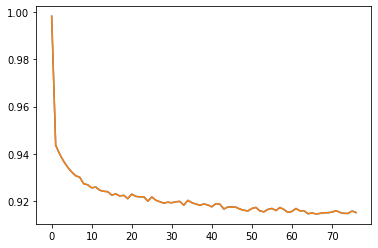

0.12766335898123693


In [ ]:
plt.plot(epoch, [x.detach() for x in train_losses], [x.detach() for x in val_losses])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## With embedding

In [ ]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding 

        self.seq = nn.Sequential(
            nn.Linear(263,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.ReLU(nn.BatchNorm1d(32)),
            nn.Dropout(0.5),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

In [333]:
X_train[:,7:].int()

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [329]:
emb = nn.Embedding(10,3, sparse = True)

In [ ]:
[-0.2680,  0.0216,  0.9065]-0.2680,  0.0216,  0.9065

In [344]:
X_train[2,7:].int().argmax()

tensor(146)

In [345]:
emb(X_train[:,7:].int())[2,:,:]

tensor([[-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
 

In [319]:
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
emb(input)

tensor([[[-1.1585,  2.0188,  2.1123],
         [ 0.7063, -1.2334, -0.2562],
         [-1.9014,  0.3058,  0.3674],
         [ 0.5342, -1.6928, -0.4252]],

        [[-1.9014,  0.3058,  0.3674],
         [ 1.0778,  0.6448,  0.6322],
         [ 0.7063, -1.2334, -0.2562],
         [-1.2688, -0.6102,  0.4146]]], grad_fn=<EmbeddingBackward0>)

In [291]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*lz).*$')-train_data.filter(regex = '^(?!.*lz).*$').mean())/train_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), train_data.filter(regex = 'lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*lz).*$')-val_data.filter(regex = '^(?!.*lz).*$').mean())/val_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), val_data.filter(regex = 'lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*lz).*$')-test_data.filter(regex = '^(?!.*lz).*$').mean())/test_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), test_data.filter(regex = 'lz')], axis = 1)

In [292]:
X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [294]:
X_train

tensor([[-0.8179,  1.5905,  1.2673,  ...,  0.0000,  0.0000,  0.0000],
        [-0.9438, -0.6287, -0.3807,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5665, -0.6287,  0.0636,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.8667, -0.6287, -2.1659,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.3635, -0.6287,  1.2673,  ...,  0.0000,  0.0000,  0.0000],
        [-1.9926, -0.6287,  0.0636,  ...,  0.0000,  0.0000,  0.0000]])

## With degree

In [269]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

# No more than 3 days
df = df[df.time_to_reservation < 72]

# Remove zones with too little support
df = df[~df.leave_zone.isin((df.leave_zone.value_counts() < 30).index[df.leave_zone.value_counts() < 30])]

df = pd.get_dummies(df, columns = ['engine','leave_zone'], prefix=['eng','lz'])


y = df.time_to_reservation
df.drop(columns=['time_to_reservation', 'time', 'park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'leave_fuel', 'park_zone', 'moved', 'movedTF'], inplace = True)

In [270]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [271]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(269,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.ReLU(nn.BatchNorm1d(32)),
            nn.Dropout(0.5),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=269, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
) 45377


In [272]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1 : Train Loss 0.272323 , Train acc 0.124424, Valid acc 0.118452
Epoch 11 : Train Loss 0.221885 , Train acc 0.193627, Valid acc 0.167536
Epoch 21 : Train Loss 0.217789 , Train acc 0.206418, Valid acc 0.173498
Epoch 31 : Train Loss 0.216244 , Train acc 0.208541, Valid acc 0.172653
Epoch 41 : Train Loss 0.215803 , Train acc 0.208410, Valid acc 0.169930
Epoch 51 : Train Loss 0.215807 , Train acc 0.211432, Valid acc 0.170016
Epoch 61 : Train Loss 0.215692 , Train acc 0.210552, Valid acc 0.168451
Epoch 71 : Train Loss 0.214552 , Train acc 0.209774, Valid acc 0.167269
Epoch 81 : Train Loss 0.214992 , Train acc 0.213317, Valid acc 0.168102
Epoch 91 : Train Loss 0.214717 , Train acc 0.212741, Valid acc 0.167908
Epoch 101 : Train Loss 0.214257 , Train acc 0.216156, Valid acc 0.169003
Epoch 111 : Train Loss 0.213961 , Train acc 0.214654, Valid acc 0.167620
Epoch 121 : Train Loss 0.214330 , Train acc 0.214331, Valid acc 0.166720


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

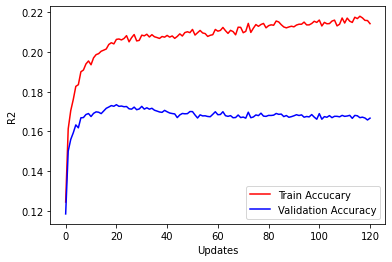

In [273]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

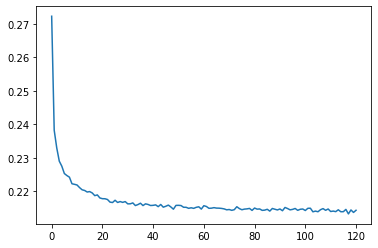

0.1751694135769265


In [274]:
plt.plot([x.detach() for x in losses])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## With weather

In [275]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

# No more than 4 days
df = df[df.time_to_reservation < 72]

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

# Remove zones with too little support
df = df[~df.leave_zone.isin((df.leave_zone.value_counts() < 30).index[df.leave_zone.value_counts() < 30])]

df = pd.get_dummies(df, columns = ['engine','leave_zone'], prefix=['eng','lz'])

# Joine weather
df_weather = pd.read_csv('data/processed/weather.csv', index_col=0, parse_dates=[0])
df.time = df.time.round('H')
df = df.set_index('time').join(df_weather).reset_index()
del df_weather

# Make y and x
y = df.time_to_reservation
df.drop(columns=['time_to_reservation', 'index', 'park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'leave_fuel', 'park_zone', 'moved', 'movedTF'], inplace = True)

In [276]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [277]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(276,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            #nn.Linear(64,64),
            #nn.ReLU(nn.BatchNorm1d(64)),
            #nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=276, out_features=64, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 22209


In [278]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1 : Train Loss 0.269348 , Train acc 0.121248, Valid acc 0.116459
Epoch 11 : Train Loss 0.221772 , Train acc 0.195044, Valid acc 0.177985
Epoch 21 : Train Loss 0.219156 , Train acc 0.203671, Valid acc 0.182570
Epoch 31 : Train Loss 0.217856 , Train acc 0.209106, Valid acc 0.184004
Epoch 41 : Train Loss 0.217549 , Train acc 0.211596, Valid acc 0.184866
Epoch 51 : Train Loss 0.216298 , Train acc 0.216139, Valid acc 0.186613
Epoch 61 : Train Loss 0.215588 , Train acc 0.217900, Valid acc 0.187090
Epoch 71 : Train Loss 0.215860 , Train acc 0.217161, Valid acc 0.186224
Epoch 81 : Train Loss 0.215548 , Train acc 0.219584, Valid acc 0.186588
Epoch 91 : Train Loss 0.215690 , Train acc 0.220822, Valid acc 0.186845
Epoch 101 : Train Loss 0.215359 , Train acc 0.222144, Valid acc 0.187701


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

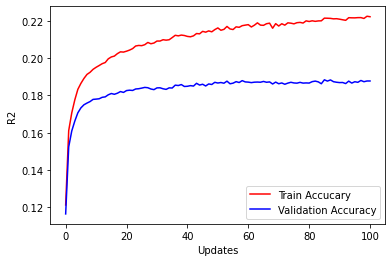

In [279]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 101
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

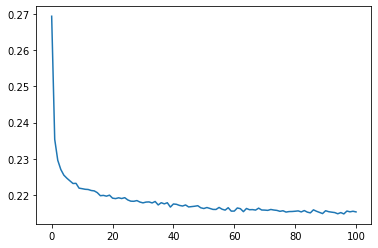

0.1904369304214959


In [280]:
plt.plot([x.detach() for x in losses])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

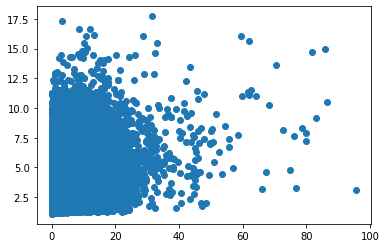

In [246]:
plt.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])

181765    154.604721
288622    156.431671
177096    159.001663
24153     159.834442
180451    162.459167
194024    171.191116
319591    178.926392
253007    181.838882
123570    182.221115
50981     183.000839
27145     187.100006
233880    189.271942
233777    198.263062
260101    198.863327
46550     201.061386
158149    201.989166
215822    206.614441
16563     222.575272
70633     232.822784
194010    232.984726
97742     261.521118
295916    268.731110
135786    292.971680
284612    310.759430
199934    344.984985
50984     375.622772
59746     468.456116
88463     470.306396
195643    521.532471
160466    796.036133
Name: time_to_reservation, dtype: float64

In [225]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

In [229]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

58